# Re-Coloring Greyscale Images Using the CIFAR-10 Dataset

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_cifar
import ops

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm

FLOAT = tf.float32

## Load In Data

In [2]:
batches = load_cifar.Batches()
train_batches = batches[:5]
train_images = np.concatenate(train_batches)
test_batch = batches[5]

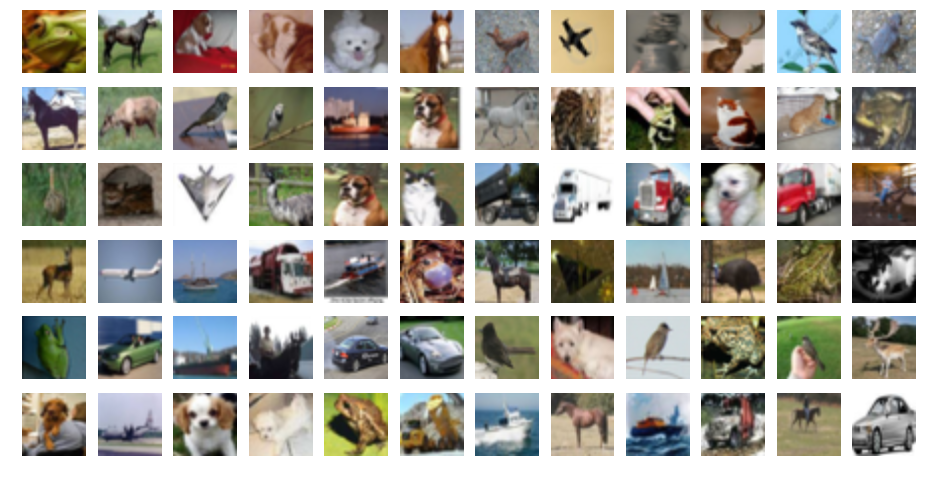

In [3]:
figsize(16, 8)
_, ax = plt.subplots(6, 12)
for a in ax.reshape(np.prod(ax.shape)):
    a.imshow(train_images[np.random.randint(0, 10000)])
    a.axis("off")
plt.show()

## Some Utility Functions

In [4]:
# Works on both np.ndarray and tf.Tensor!
def Luminosity(color_images):
    return (
        color_images[:, :, :, 0] * 0.38 + 
        color_images[:, :, :, 1] * 0.75 +
        color_images[:, :, :, 2] * 0.14)

def PixelwiseChannelSoftmax(images):
    exps = tf.exp(images)
    sums = tf.reduce_sum(exps, 3, keep_dims=True)
    return exps / sums
    

## The Network

In [5]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


#### Internal Structurea and Outputs

In [6]:
# Input a stack of 32 x 32 x 3 RGB images, color values scaled from 0 to 1
color_inputs = tf.placeholder(FLOAT, [None, 32, 32, 3], name="color_inputs")

# Convert to greyscale
greyscale_inputs = tf.reshape(
    Luminosity(color_inputs),
    [-1, 32, 32, 1],
    name="greyscale_inputs")

# Convolutional alyers, no max pooling.
conv_1 = ops.ConvLayer(greyscale_inputs, 5, 32, ops.ELU, "Conv1")
conv_2 = ops.ConvLayer(conv_1, 3, 32, ops.ELU, "Conv2")
conv_3 = ops.ConvLayer(conv_2, 3, 32, ops.ELU, "Conv3")
conv_out = ops.ConvLayer(conv_3, 3, 3, tf.nn.sigmoid, "ConvOut")

# Output
softmax_out = PixelwiseChannelSoftmax(conv_out)
raw_image_out = tf.clip_by_value(greyscale_inputs * conv_out, 0, 1)
image_out = tf.clip_by_value(greyscale_inputs * softmax_out * 2.3, 0, 1)

#### Error, Evaluation, and Training

In [7]:
softmax_inputs = PixelwiseChannelSoftmax(color_inputs)
xent = -tf.reduce_mean(softmax_inputs * tf.log(softmax_out))
learn_rate = tf.placeholder(FLOAT, [], name="learn_rate")
train_step = tf.train.AdagradOptimizer(learn_rate).minimize(xent)

#### Initialize

In [8]:
sess.run(tf.initialize_all_variables())

#### Main Loop

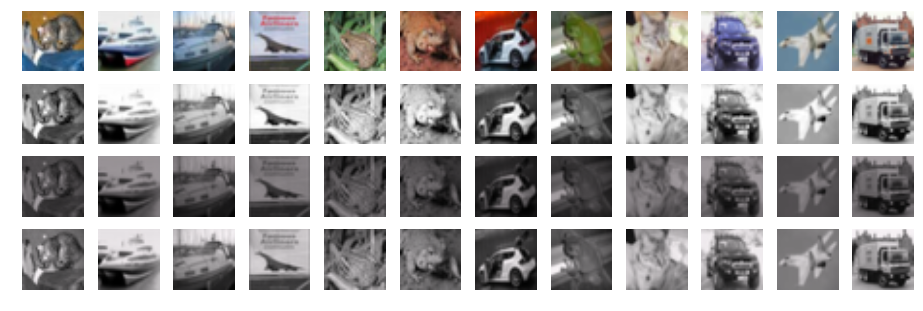


Epoch 0, Batch 0 of 500 after 137.7 seconds: x-ent=0.357247
..................................................
Epoch 0, Batch 50 of 500 after 315.7 seconds: x-ent=0.357248
..................................................
Epoch 0, Batch 100 of 500 after 493.5 seconds: x-ent=0.357248
...............

KeyboardInterrupt: 

In [12]:
num_epochs = 1
batch_size = 100
test_every_n_batches = 50

figsize(16, 5)
show_examples = True

batches_per_epoch = train_images.shape[0] / batch_size
mark = time.time()
for ep in xrange(num_epochs):
    np.random.shuffle(train_images)

    if show_examples:
        grey, val_xent, raw_out, soft_out = sess.run(
            [greyscale_inputs, xent, raw_image_out, image_out],
            feed_dict={
                color_inputs: test_batch[:12]})    
        _, ax = plt.subplots(4, 12)
        for im in xrange(12):
            ax[0][im].imshow(test_batch[im])
            ax[0][im].axis("off")
            ax[1][im].imshow(grey[im].reshape((32, 32)), cmap=cm.Greys_r)
            ax[1][im].axis("off")
            ax[2][im].imshow(raw_out[im])
            ax[2][im].axis("off")
            ax[3][im].imshow(soft_out[im])
            ax[3][im].axis("off")
        plt.show()

    for i in xrange(batches_per_epoch):
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            color_inputs: train_images[start_offset:stop_offset],
            learn_rate: 0.001
            })
        
        if (i) % test_every_n_batches == 0:
            val_xent = xent.eval(feed_dict={color_inputs: test_batch})
            print "\nEpoch {e}, Batch {b} of {z} after {s:.1f} seconds: x-ent={x:.6f}".format(
              e=ep, b=i, z=batches_per_epoch, s=time.time() - mark, x=val_xent)
        
        sys.stdout.write(".")

### Foolin Around

In [ ]:


figsize(8, 1.5)

for x in xrange(10):
    _, ax = plt.subplots(1, 5)
    ax[0].imshow(test_batch[x])
    ax[1].imshow(np.clip(gsi[x] * si[x] * 2.2, 0, 1))
    ax[2].imshow(gsi[x].reshape((32, 32)), cmap=cm.Greys_r)
    ax[3].imshow(np.clip(io[x] * 2.2, 0, 1))
    ax[4].imshow(co[x])
    for a in ax:
        a.axis("off")
    plt.show()